In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [3]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)}
itol = {i: l for l, i in ltoi.items()}

In [4]:
from transformers import AutoTokenizer

model_checkpoint = "microsoft/deberta-v3-base" # Or deberta-v3-large, etc.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Check if the tokenizer is a fast tokenizer (it should be for DeBERTa-v3)
assert tokenizer.is_fast, "Only fast tokenizers are supported for this example."

/user/HS400/rl01179/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [5]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=512,
        padding="max_length"
    )

    aligned_labels_batch = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids_for_sequence = []
        for word_idx in word_ids:
            if word_idx is None:  # Special tokens ([CLS], [SEP]) or padding
                label_ids_for_sequence.append(ltoi["O"]) # Assign 'O', will be masked by CRF if padding
            elif word_idx != previous_word_idx:  # First token of a new word
                label_ids_for_sequence.append(ltoi[label_sequence[word_idx]])
            else:  # Subsequent tokens of the same word
                current_label_str = label_sequence[word_idx]
                # Propagate I-tag if B-tag, otherwise keep current tag (O or I-tag)
                if current_label_str.startswith("B-"):
                    related_i_tag = "I-" + current_label_str[2:]
                    if related_i_tag in ltoi:
                        label_ids_for_sequence.append(ltoi[related_i_tag])
                    else: # No specific I-tag, e.g. B-AC without I-AC
                        label_ids_for_sequence.append(ltoi[current_label_str]) # or ltoi["O"]
                else:
                    label_ids_for_sequence.append(ltoi[current_label_str])
            previous_word_idx = word_idx
        aligned_labels_batch.append(label_ids_for_sequence)
    tokenized_inputs["labels"] = aligned_labels_batch
    return tokenized_inputs

In [6]:
data = dataset.map(tokenize_and_align_labels, batched = True)

In [7]:
train_data, train_labels, train_attention_mask = data['train']['input_ids'], data['train']['labels'], data['train']['attention_mask']
val_data, val_labels, val_attention_mask = data['validation']['input_ids'], data['validation']['labels'], data['validation']['attention_mask']
test_data, test_labels, test_attention_mask = data['test']['input_ids'], data['test']['labels'], data['test']['attention_mask']

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

def get_batch(split = "train"):
  data = train_data if split == "train" else val_data
  labels = train_labels if split == "train" else val_labels
  attention_mask = train_attention_mask if split == "train" else val_attention_mask
  ix = torch.randint(len(data), (batch_size,))
  x = torch.stack([torch.tensor(data[i]).long() for i in ix])
  y = torch.stack([torch.tensor(labels[i]).long() for i in ix])
  a = torch.stack([torch.tensor(attention_mask[i]) for i in ix])
  return x.to(device), y.to(device), a.to(device)

@torch.no_grad()
def estimate_loss(eval_steps):
    out = {}
    model.eval()
    
    for split in ["train", "validation"]:
        losses = torch.zeros(eval_steps)
        correct_tokens = 0
        total_tokens = 0

        for k in range(eval_steps):
            x, y, a = get_batch(split) 
            loss, logits = model(x, attention_mask=a, labels = y)
            losses[k] = loss.item()

            # Accuracy calculation
            preds = logits.argmax(dim=-1)
            mask = (y != 0)  # optional: ignore padding label if using -100
            correct = (preds == y) & mask
            correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

        avg_loss = losses.mean().item()
        avg_acc = correct_tokens / total_tokens if total_tokens > 0 else 0.0
        out[split] = {"loss": avg_loss, "accuracy": avg_acc}

    model.train()
    return out


from seqeval.metrics import precision_score, classification_report, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

@torch.no_grad()
def evaluate_model(model, split="test"):
    model.eval()
    
    if split == "test":
        data_input_ids = test_data
        data_labels = test_labels
        data_attention_mask = test_attention_mask
    elif split == "validation":
        data_input_ids = val_data
        data_labels = val_labels
        data_attention_mask = val_attention_mask
    else:
        data_input_ids = train_data
        data_labels = train_labels
        data_attention_mask = train_attention_mask
    
    # Process in smaller batches to avoid OOM
    batch_size_eval = 16
    all_true_labels = []
    all_pred_labels = []
    
    # Process the entire dataset
    for i in tqdm(range(0, len(data_input_ids), batch_size_eval), desc=f"Evaluating on {split}"):
        # Get batch
        batch_input_ids = torch.tensor(data_input_ids[i:i+batch_size_eval]).to(device)
        batch_labels = torch.tensor(data_labels[i:i+batch_size_eval]).to(device)
        batch_attention_mask = torch.tensor(data_attention_mask[i:i+batch_size_eval]).to(device)
        
        # Get predictions
        _, logits = model(batch_input_ids, attention_mask=batch_attention_mask)
        preds = logits.argmax(-1)
        
        # Convert predictions and labels to lists for seqeval
        for j in range(len(batch_input_ids)):
            true_label_ids = batch_labels[j].cpu().numpy()
            pred_label_ids = preds[j].cpu().numpy()
            
            # Convert IDs to labels, handling special tokens
            true_seq = []
            pred_seq = []
            
            for true_id, pred_id, mask in zip(true_label_ids, pred_label_ids, batch_attention_mask[j]):
                if mask == 1 and true_id != 0:  # Only evaluate on non-padding and non-special tokens
                    true_seq.append(itol[true_id.item()])
                    pred_seq.append(itol[pred_id])
            
            if true_seq:  # Only add if not empty
                all_true_labels.append(true_seq)
                all_pred_labels.append(pred_seq)
    print(all_pred_labels[0], all_true_labels[0])
    # Calculate metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    report = classification_report(all_true_labels, all_pred_labels)
    
    print(f"\n=== Evaluation on {split} split ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nDetailed Classification Report:")
    print(report)

    flat_true = [ltoi[l] for seq in all_true_labels for l in seq]
    flat_pred = [ltoi[l] for seq in all_pred_labels for l in seq]

    cm = confusion_matrix(flat_true, flat_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(8, 6))  
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "report": report
    }

In [92]:
from transformers import AutoModelForTokenClassification
from torchcrf import CRF

In [93]:
class DebertaCrfForTokenClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels, id2label, label2id):
        super().__init__()
        self.num_labels = num_labels
        self.deberta = AutoModelForTokenClassification.from_pretrained(
            model_name,
            num_labels=num_labels, # DeBERTa's classifier head outputs scores for each label
            id2label=id2label,
            label2id=label2id
        )
        
        self.deberta.classifier = nn.LSTM(768, 128, num_layers=1, bidirectional=True, batch_first=True)

        self.logits = nn.Linear(128*2, num_labels)

        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        x, _= self.deberta(input_ids=input_ids, attention_mask=attention_mask).logits
        x = self.logits(x)

        if labels is not None:
            loss = -self.crf(x, labels, mask=attention_mask.bool(), reduction='mean')
            return loss, x
        else:

            decoded_tags = self.crf.decode(x, mask=attention_mask.bool())
            return decoded_tags, x


In [94]:
model = DebertaCrfForTokenClassification(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
from tqdm import tqdm

optim = torch.optim.AdamW(model.parameters(), lr = 3e-5)
max_steps = 500

In [96]:
import matplotlib.pyplot as plt

  0%|          | 1/500 [00:44<6:09:47, 44.46s/it]

step 0: train loss 57.6049, acc 0.1350 | val loss 59.3718, acc 0.1318


 20%|██        | 101/500 [02:12<1:31:53, 13.82s/it]

step 100: train loss 15.0412, acc 0.8369 | val loss 17.4228, acc 0.8157


 40%|████      | 201/500 [03:41<1:08:56, 13.83s/it]

step 200: train loss 10.4692, acc 0.9287 | val loss 13.3702, acc 0.8981


 60%|██████    | 301/500 [05:10<45:50, 13.82s/it]  

step 300: train loss 11.0487, acc 0.9328 | val loss 14.2947, acc 0.8920


 80%|████████  | 401/500 [06:38<22:49, 13.83s/it]

step 400: train loss 7.8909, acc 0.9509 | val loss 14.0410, acc 0.8926


100%|██████████| 500/500 [07:21<00:00,  1.13it/s]


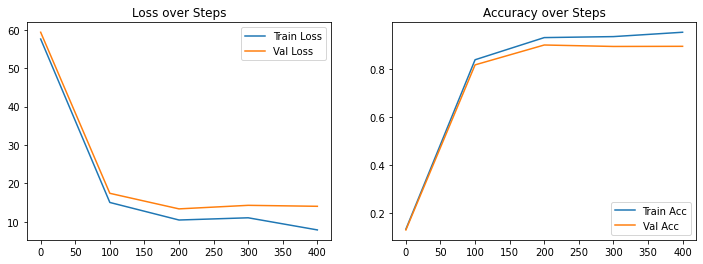

In [97]:
lossi = []
lri = []

train_loss_step = []
train_acc_step = []
val_loss_step = []
val_acc_step = []
eval_step = []

for step in tqdm(range(max_steps)):
  # for g in optim.param_groups:
  #   g['lr'] = lrs[step]

  x, y, a = get_batch("train")
  optim.zero_grad()
  with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    loss, logits = model(x, attention_mask = a, labels = y)
  loss.backward()
  optim.step()
  # lri.append(lre[step])
  # lossi.append(loss.item())
  if step % 100 == 0:
    metrics = estimate_loss(100)
    print(f"step {step}: "
          f"train loss {metrics['train']['loss']:.4f}, acc {metrics['train']['accuracy']:.4f} | "
          f"val loss {metrics['validation']['loss']:.4f}, acc {metrics['validation']['accuracy']:.4f}")
    train_loss_step.append(metrics['train']['loss'])
    train_acc_step.append(metrics['train']['accuracy'])
    val_loss_step.append(metrics['validation']['loss'])
    val_acc_step.append(metrics['validation']['accuracy'])
    eval_step.append(step)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(eval_step, train_loss_step, label='Train Loss')
plt.plot(eval_step, val_loss_step, label='Val Loss')
plt.legend()
plt.title("Loss over Steps")

plt.subplot(1, 2, 2)
plt.plot(eval_step, train_acc_step, label='Train Acc')
plt.plot(eval_step, val_acc_step, label='Val Acc')
plt.legend()
plt.title("Accuracy over Steps")

plt.show()

Evaluating on test: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

['B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-LF', 'I-LF', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-AC'] ['B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-LF', 'I-LF', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-AC']

=== Evaluation on test split ===
F1 Score: 0.9681
Precision: 0.9787
Recall: 0.9578

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       1.00      0.97      0.98      1342
          LF       0.93      0.93      0.93       482

   micro avg       0.98      0.96      0.97      1824
   macro avg       0.96      0.95      0.96      1824
weighted avg       0.98      0.96      0.97      1824



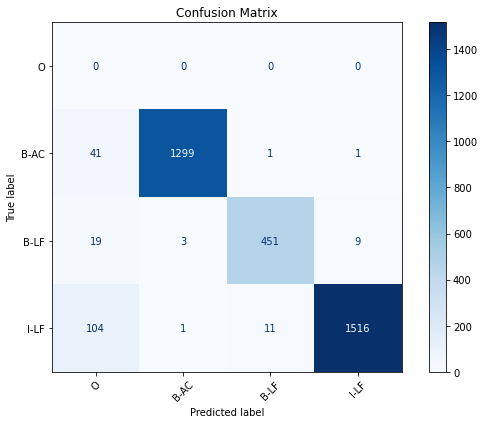

{'f1': 0.9681352175117761,
 'precision': 0.9787114845938375,
 'recall': 0.9577850877192983,
 'report': '              precision    recall  f1-score   support\n\n          AC       1.00      0.97      0.98      1342\n          LF       0.93      0.93      0.93       482\n\n   micro avg       0.98      0.96      0.97      1824\n   macro avg       0.96      0.95      0.96      1824\nweighted avg       0.98      0.96      0.97      1824\n'}

In [108]:
evaluate_model(model, split = 'test')